# COVID-19 Prediction Analysis

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [3]:
#Import connection dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import psycopg2

In [4]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score, confusion_matrix
# from imblearn.metrics import classificationn_report_imbalanced 
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

# import keras_tuner as kt

### Data Source

**Our World in Data COVID-19 Dataset Citation**
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: [Our World In Data / Coronavirus](https://ourworldindata.org/coronavirus)

In [5]:
# Create connection to SQL database
conn = psycopg2.connect(
    host="finalproject.cjgqtjwgyywe.us-east-2.rds.amazonaws.com",
    database="postgres",
    user="postgres",
    password="FinalProject1")

In [6]:
# Read the OneWorldInData COVID-19 database into a DataFrame
df = pd.read_sql("SELECT * from all_countries_data", conn)
print(df.shape)
df.head()

(187000, 68)


,id_row,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,99331,LBN,Asia,Lebanon,2020-03-01,10.0,6.0,1.286,NaN,NaN,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
1,31,AFG,Asia,Afghanistan,2020-03-26,80.0,6.0,8.000,2.0,1.0,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,99395,LBN,Asia,Lebanon,2020-05-04,740.0,3.0,4.286,25.0,0.0,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
3,99426,LBN,Asia,Lebanon,2020-06-04,1306.0,50.0,19.714,28.0,1.0,...,26.9,40.7,NaN,2.9,78.93,0.744,NaN,NaN,NaN,NaN
4,131,AFG,Asia,Afghanistan,2020-07-04,32758.0,348.0,293.714,830.0,7.0,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [7]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(187000, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
id_row,,,,,,,,,,,,,,,,,,,,,
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [8]:
# Check non-null counts and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187000 entries, 0 to 198845
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    187000 non-null  object 
 1   continent                                   187000 non-null  object 
 2   location                                    187000 non-null  object 
 3   date                                        187000 non-null  object 
 4   total_cases                                 179392 non-null  float64
 5   new_cases                                   179111 non-null  float64
 6   new_cases_smoothed                          177999 non-null  float64
 7   total_deaths                                160966 non-null  float64
 8   new_deaths                                  160731 non-null  float64
 9   new_deaths_smoothed                         159637 non-null  float64
 

In [9]:
# Count the records in the COVID-19 DataFrame.
records = df["location"].count()
print(f"There are {records} location-specific records in the OWID COVID-19 dataset as of July 5th, 2022.")

There are 187000 location-specific records in the OWID COVID-19 dataset as of July 5th, 2022.


In [10]:
# Check the earliest and latest date in the dataset. 
df["date"].sort_values()

id_row
6822      2020-01-01
115431    2020-01-01
6823      2020-01-02
115432    2020-01-02
115433    2020-01-03
             ...    
18933     2022-07-04
50735     2022-07-04
121987    2022-07-04
49879     2022-07-04
198845    2022-07-04
Name: date, Length: 187000, dtype: object

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

In [11]:
# Count the unique locations included in the COVID-19 dataset. 
countries_count = len(df["location"].unique())
print(f"There are {countries_count} unique values in the OWID COVID-19 location column.")

There are 230 unique values in the OWID COVID-19 location column.


In [12]:
# List the locations included in the COVID-19 dataset.
locations_list = df["location"].unique()
print(f"Locations list: {locations_list}")

Locations list: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Curacao' 'Cyprus' 'Czechia' 'Democratic Republic of Congo' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Faeroe Islands' 'Falkland Islands' 'Fiji' 'Finland' 'France'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibraltar' 'Greece' 'Gre

## Data Manipulation

There are 2 intended purposes of the prediction models: 
1. Predicting the daily number of new COVID-19 cases per 100,000 people in all included countries/regions.
2. Predicting the daily number of new COVID-19-related deaths per 1,000 people in all included countries/regions. 

#### Removing Irrelevant Variables

In [13]:
# Drop all columns related to COVID-19 testing. 
tests_drop = ['total_tests', 'new_tests', 'total_tests_per_thousand', 
             'new_tests_per_thousand', 'new_tests_smoothed', 
             'new_tests_smoothed_per_thousand', 'positive_rate', 
             'tests_per_case', 'tests_units']
no_test_df = df.drop(columns=tests_drop, axis=1)
print(no_test_df.shape)

(187000, 58)


In [14]:
# Drop all columns related to calculated excess_mortality.
mortality_drop = ['excess_mortality', 'excess_mortality_cumulative',
                  'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million']
no_mortality_df = no_test_df.drop(columns=mortality_drop, axis=1)
print(no_mortality_df.shape)        

(187000, 54)


In [15]:
# Drop unnecessary general columns. 
general_drop = ['iso_code', 'continent', 'aged_70_older']
general_df = no_mortality_df.drop(columns=general_drop, axis=1)
print(general_df.shape)

(187000, 51)


#### Two-Year Worth of COVID-19 Reporting

There are 916 days between January 1st, 2020 and July 4th, 2020 (both days included). <br>
We will keep locations with two-year worth of records each to establish a good amount historical data points for prediction models. <br>
Two_year worth of daily records = 730 records

In [16]:
# Check the count of records for all locations.
all_locations_recs = general_df.location.value_counts()
all_locations_recs

Mexico            916
Argentina         916
Thailand          913
Taiwan            901
South Korea       895
                 ... 
Palau             317
Niue              266
Tokelau           114
Pitcairn           85
Western Sahara      1
Name: location, Length: 230, dtype: int64

<AxesSubplot:ylabel='Density'>

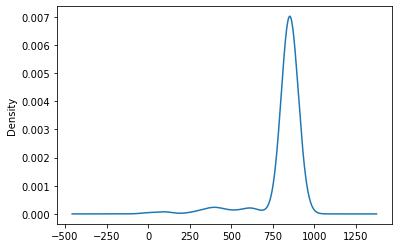

In [17]:
# Visualize the records counts for all locations. 
all_locations_recs.plot.density()

In [18]:
# Get the locations with less than 730 records.
low_rec_locations= {}
for key, value in all_locations_recs.items():
    if value < 730:
        location = {key: value}
        low_rec_locations.update(location)
print(f"There are {len(low_rec_locations)} locations with less than 730 daily records.")
print(f"These locations are: ")
low_rec_locations

There are 21 locations with less than 730 daily records.
These locations are: 


{'Saint Helena': 666,
 'Solomon Islands': 631,
 'Wallis and Futuna': 624,
 'Northern Mariana Islands': 610,
 'Vanuatu': 602,
 'Samoa': 594,
 'Micronesia (country)': 530,
 'Guernsey': 520,
 'Jersey': 470,
 'Tonga': 441,
 'Sint Maarten (Dutch part)': 414,
 'Kiribati': 413,
 'Cook Islands': 410,
 'Turkmenistan': 372,
 'Nauru': 369,
 'Tuvalu': 344,
 'Palau': 317,
 'Niue': 266,
 'Tokelau': 114,
 'Pitcairn': 85,
 'Western Sahara': 1}

In [19]:
# Bucket all locations with less than 2yrs of records into "other" bin.
for area in low_rec_locations:
    general_df.location = general_df.location.replace(area, "other")
# Check that binning was successful
general_df.location.value_counts()

other               8793
Mexico               916
Argentina            916
Thailand             913
Taiwan               901
                    ... 
Comoros              796
Tajikistan           795
Marshall Islands     789
Lesotho              783
North Korea          781
Name: location, Length: 210, dtype: int64

In [20]:
# Create a new DataFrame of locations with at least 2yr of records.
general_2yr_df = general_df[general_df.location != 'other']
print(general_2yr_df.shape)
general_2yr_df.head()

(178207, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [21]:
# Check successful filtering based on number of records for each location.
general_2yr_df.location.value_counts()

Mexico              916
Argentina           916
Thailand            913
Taiwan              901
United States       895
                   ... 
Comoros             796
Tajikistan          795
Marshall Islands    789
Lesotho             783
North Korea         781
Name: location, Length: 209, dtype: int64

#### Vaccinations Transformation

OWID notes:
- Vaccinations data were updated daily for 218 locations of the original dataset  (218/244).
- On 6 January 2021, we added two variables for daily vaccinations to our complete dataset.
- On 26 January 2021, we added 4 variables on people vaccinated and people fully vaccinated to our complete dataset.
- On 11 August 2021, we added the metric total_boosters to our vaccination data. This counts the total number of booster doses (doses administered beyond the number prescribed by the vaccination protocol).
- On 15 November 2021, we added the metrics new_people_vaccinated_smoothed and new_people_vaccinated_smoothed_per_hundred to our vaccination data. They count the daily number of people receiving their first vaccine dose.
- Since 29 March 2022, vaccination data is no longer updated on a daily basis. Updates now are only on weekdays (Monday until Friday).

We will fill the vaccinations nulls with zeros because the absence of vaccines emphasizes certain trends in the pandemic; hence, vaccines initiation is expected to decrease the number of cases and covid-related deaths. 

###### We presume that vaccination  have played an integral role in the COVID-19 pandemic trajectory, and its influence may be observed over both cases and deaths.

In [22]:
# Create a new DataFrame of countries with vaccination data.
vaccination_df = general_2yr_df.loc[general_2yr_df.total_vaccinations.notnull()]
print(vaccination_df.shape)
vaccination_df.head()

(47620, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
364,Afghanistan,2021-02-22,55617.0,13.0,14.714,2433.0,1.0,0.857,1396.169,0.326,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
370,Afghanistan,2021-02-28,55714.0,7.0,15.714,2443.0,0.0,1.571,1398.604,0.176,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
386,Afghanistan,2021-03-16,55995.0,10.0,17.000,2460.0,1.0,1.286,1405.658,0.251,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
408,Afghanistan,2021-04-07,56873.0,94.0,59.857,2512.0,0.0,4.000,1427.699,2.360,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
423,Afghanistan,2021-04-22,58312.0,98.0,111.143,2561.0,4.0,4.000,1463.823,2.460,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


**There are 47,620 records of vaccinations from all locations.**

In [23]:
# Check the list of locations 
vaccination_df.location.nunique()

201

**There are 201 locations with vaccinations data.**

In [24]:
# Check the count of vaccinations per location
vaccination_df.location.value_counts()

Norway                             570
Denmark                            567
Canada                             564
Israel                             563
United States                      563
                                  ... 
Bosnia and Herzegovina              20
Tanzania                            17
Lesotho                             17
Falkland Islands                     6
Bonaire Sint Eustatius and Saba      2
Name: location, Length: 201, dtype: int64

In [25]:
# Check the first date of vaccination on record.
vaccination_df.date.sort_values()

id_row
134855    2020-12-02
98744     2020-12-04
98747     2020-12-07
134861    2020-12-08
47632     2020-12-08
             ...    
138049    2022-07-04
148728    2022-07-04
70516     2022-07-04
12967     2022-07-04
175006    2022-07-04
Name: date, Length: 47620, dtype: object

**The earliest time for vaccinations in the data is December 2nd, 2020.**

We will investigate whether the daily new and total vaccinations numbers are affected after March 29, 2022.

In [26]:
vac_df = general_2yr_df[['location', 'date', 'new_cases', 'total_cases', 'new_vaccinations','total_vaccinations', 'people_fully_vaccinated']]
vac_df.tail(20)

,location,date,new_cases,total_cases,new_vaccinations,total_vaccinations,people_fully_vaccinated
id_row,,,,,,,
198826,Zimbabwe,2022-06-15,232.0,254387.0,7481.0,11866991.0,4567466.0
198827,Zimbabwe,2022-06-16,115.0,254502.0,7126.0,11874117.0,4570349.0
198828,Zimbabwe,2022-06-17,251.0,254753.0,11967.0,11886084.0,4575674.0
198829,Zimbabwe,2022-06-18,0.0,254753.0,3295.0,11889379.0,4576849.0
198830,Zimbabwe,2022-06-19,48.0,254801.0,6250.0,11895629.0,4578232.0
198831,Zimbabwe,2022-06-20,30.0,254831.0,NaN,NaN,NaN
198832,Zimbabwe,2022-06-21,88.0,254919.0,NaN,11910337.0,4583367.0
198833,Zimbabwe,2022-06-22,130.0,255049.0,11366.0,11921703.0,4588340.0
198834,Zimbabwe,2022-06-23,87.0,255136.0,7628.0,11929331.0,4591475.0


In [27]:
# Check another location for weekend reporting effect
us_vac_df = general_2yr_df.loc[general_2yr_df['location'] == 'United States']
us = us_vac_df[['location', 'date', 'new_cases', 'total_cases', 'new_vaccinations','total_vaccinations', 'people_fully_vaccinated']]
us.tail(20)

,location,date,new_cases,total_cases,new_vaccinations,total_vaccinations,people_fully_vaccinated
id_row,,,,,,,
188225,United States,2022-06-15,184905.0,86031984.0,274522.0,593872178.0,221991405.0
188226,United States,2022-06-16,130123.0,86162107.0,270923.0,594143101.0,222023745.0
188227,United States,2022-06-17,139238.0,86301345.0,287979.0,594431080.0,222059017.0
188228,United States,2022-06-18,16295.0,86317640.0,127802.0,594558882.0,222076416.0
188229,United States,2022-06-19,9900.0,86327540.0,60975.0,594619857.0,222085264.0
188230,United States,2022-06-20,93568.0,86421108.0,225463.0,594845320.0,222110248.0
188231,United States,2022-06-21,114642.0,86535750.0,246070.0,595091390.0,222140177.0
188232,United States,2022-06-22,184065.0,86719815.0,251782.0,595343172.0,222170345.0
188233,United States,2022-06-23,148157.0,86867972.0,250826.0,595593998.0,222198722.0


**The change in vaccinations reporting frequency from daily to weekdays only does seem to have affected the daily numbers in the dataset in certain locations.**

1. **We will shorten the window of analysis up until the reporting change took effect (March 29th, 2022).**
2. **Then, we will replace all the vaccinations with null values to zero because it indicates the absence of vaccinations and its affect on the spread of COVID-19.**

In [28]:
# Convert the 'date' column to a datetime.
general_2yr_df['date'] = general_2yr_df['date'].apply(pd.to_datetime)
print(general_2yr_df.date.dtype)

datetime64[ns]


In [30]:
# Create a DataFrame before March 29, 2022
mar_general_df = general_2yr_df.copy()
mar_general_df = mar_general_df.loc[mar_general_df['date'] < '2022-03-29']
print(mar_general_df.shape)
mar_general_df.head()

(157815, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [31]:
# Confirm date range 2020-01-01 to 2022-03-28
mar_general_df.date.sort_values()

id_row
115431   2020-01-01
6822     2020-01-01
115432   2020-01-02
6823     2020-01-02
6824     2020-01-03
            ...    
142506   2022-03-28
143393   2022-03-28
31514    2022-03-28
33245    2022-03-28
198747   2022-03-28
Name: date, Length: 157815, dtype: datetime64[ns]

In [32]:
# Check the count of locations with 2 yrs of records up till March 29, 2022.
mar_general_df.location.nunique()

209

**There are 157,815 records of 209 distinct locations with COVID-19 records between January 1st, 2020 and March 29th, 2022.**

In [33]:
# Check the records count for each location.
mar_loc_counts = mar_general_df.location.value_counts()
mar_loc_counts

Mexico              818
Argentina           818
Thailand            815
Taiwan              803
United States       797
                   ... 
Yemen               718
Comoros             698
Tajikistan          697
Marshall Islands    691
Lesotho             685
Name: location, Length: 209, dtype: int64

<AxesSubplot:ylabel='Density'>

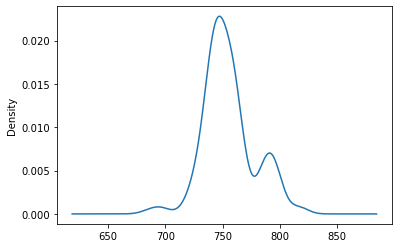

In [34]:
# Visualize locations density up till March
mar_loc_counts.plot.density()

In [35]:
# Get the locations with less than 730 records.
low_mar_loc= {}
for key, value in mar_loc_counts.items():
    if value < 730:
        location = {key: value}
        low_mar_loc.update(location)
print(f"There are {len(low_mar_loc)} locations with less than 730 daily records.")
print(f"These locations are: ")
low_mar_loc

There are 14 locations with less than 730 daily records.
These locations are: 


{'Botswana': 729,
 'Burundi': 728,
 'Sierra Leone': 728,
 'North Korea': 726,
 'Bonaire Sint Eustatius and Saba': 726,
 'Falkland Islands': 724,
 'Saint Pierre and Miquelon': 723,
 'South Sudan': 723,
 'Sao Tome and Principe': 722,
 'Yemen': 718,
 'Comoros': 698,
 'Tajikistan': 697,
 'Marshall Islands': 691,
 'Lesotho': 685}

In [36]:
# Bucket all locations with less than 2yrs of records into "other" bin.
mar_general_2yr_df = mar_general_df.copy()
for area in low_mar_loc:
    mar_general_2yr_df.location = mar_general_2yr_df.location.replace(area, "other")
# Check that binning was successful
mar_general_2yr_df.location.value_counts()

other                       10018
Argentina                     818
Mexico                        818
Thailand                      815
Taiwan                        803
                            ...  
Myanmar                       732
Turks and Caicos Islands      731
Anguilla                      731
British Virgin Islands        731
Malawi                        730
Name: location, Length: 196, dtype: int64

In [37]:
# Drop 'other' location bucket from DataFrame.
mar_general_2yr_df = mar_general_2yr_df[mar_general_2yr_df.location != 'other']
print(mar_general_2yr_df.shape)
mar_general_2yr_df.head()

(147797, 51)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [38]:
# Check the number of locations.
mar_general_2yr_df.location.nunique()

195

**There are 147,797 records of 195 distinct locations with 2-yr worth of COVID-19 records between January 1st, 2020 and March 29th, 2022.**

In [39]:
# Confirm 2-yr value counts
mar_general_2yr_df.location.value_counts()

Mexico                      818
Argentina                   818
Thailand                    815
Taiwan                      803
China                       797
                           ... 
Myanmar                     732
Turks and Caicos Islands    731
Anguilla                    731
British Virgin Islands      731
Malawi                      730
Name: location, Length: 195, dtype: int64

#### Cleaning Null Values

In [40]:
mar_general_2yr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147797 entries, 0 to 198747
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   location                                    147797 non-null  object        
 1   date                                        147797 non-null  datetime64[ns]
 2   total_cases                                 145096 non-null  float64       
 3   new_cases                                   144983 non-null  float64       
 4   new_cases_smoothed                          143994 non-null  float64       
 5   total_deaths                                132715 non-null  float64       
 6   new_deaths                                  132574 non-null  float64       
 7   new_deaths_smoothed                         131588 non-null  float64       
 8   total_cases_per_million                     145096 non-null  float64      

In [41]:
# Replace nulls in the vaccinations-related columns
vac_cols = ['total_vaccinations', 'people_vaccinated', 
            'people_fully_vaccinated', 'total_boosters',
           'new_vaccinations', 'new_vaccinations_smoothed',
           'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
           'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
           'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed',
           'new_people_vaccinated_smoothed_per_hundred']
mar_general_2yr_df[vac_cols] = mar_general_2yr_df[vac_cols] .fillna(0)

In [42]:
mar_general_2yr_df.total_vaccinations.isnull().sum()

0

In [43]:
mar_general_2yr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147797 entries, 0 to 198747
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   location                                    147797 non-null  object        
 1   date                                        147797 non-null  datetime64[ns]
 2   total_cases                                 145096 non-null  float64       
 3   new_cases                                   144983 non-null  float64       
 4   new_cases_smoothed                          143994 non-null  float64       
 5   total_deaths                                132715 non-null  float64       
 6   new_deaths                                  132574 non-null  float64       
 7   new_deaths_smoothed                         131588 non-null  float64       
 8   total_cases_per_million                     145096 non-null  float64      

##### Cases DataFrame to predict Number of Cases. 
- Drop rows with total_cases nulls.
- Total_cases are an input features in both models: to predict cases, to predict deaths. 
- Create a new DataFrame with no null values in total_cases
- Do not drop nulls in total_deaths because they will not be an input feature. 

In [44]:
# Check null count in total cases.
mar_general_2yr_df.total_cases.isnull().sum()

2701

In [45]:
# Drop nulls from 'total_cases'.
mar_cases_2yr_df = mar_general_2yr_df.dropna(subset =["total_cases"], how="all")
mar_cases_2yr_df['total_cases'].isnull().sum()

0

In [46]:
# Fill null values in new_cases with (0)
mar_cases_2yr_df['new_cases'] = mar_cases_2yr_df['new_cases'].fillna(0)
mar_cases_2yr_df['new_cases'].isnull().sum()

0

For the number of total cases per 100,000 people, we will not use the deaths related columns as input feautres.

Use *mar_cases_2yr_df* for cases predictions and feature engineering.

##### Deaths DataFrame to predict Number of Deaths. 

In [50]:
# Check null count in total_deaths
mar_cases_2yr_df.total_deaths.isnull().sum()

12382

There are 12,382 records with missing total_deaths values.<br>
We will use number of cases as an input feature in deaths predictions, so we will create a deaths dataframe from the cleaned cases dataframe *mar_cases_2yr_df*.

In [48]:
# Create a deaths DataFrame
mar_deaths_2yr_df = mar_cases_2yr_df.copy()
# Drop nulls from total_deaths column
mar_deaths_2yr_df = mar_deaths_2yr_df.dropna(subset=["total_deaths"], how='all')
mar_deaths_2yr_df['total_deaths'].isnull().sum()

0

Use *mar_deaths_2yr_df* for deaths predictions and feature engineering.

## Feature Engineering 

In [52]:
mar_cases_2yr_df.shape

(145096, 51)

#### Date Transformation

The date of reporting carries a significant importance in the dataset, because it conveys the state of the COVID-19 pandemic in each location in comparison to other locations at the same timescale of the health crisis. It may also highlight chronoligcal relations between other variables in the dataset. 

The first announcement of COVID-19 infections was on December 31, 2019. <br>
The World Health Organization China Country Office is informed of a number cases of pneumonia of unknown etiology (unknown cause) detected in Wuhan, Hubei Province.

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

Although COVID-19 infection did not appear in all locations of the world at the same time, it is important to compare the pandemic statue across locations at the same timescale. <br>

We will calculate the days passed between the first reporting of COVID-19 in the dataset, which is January 1st, 2020 and the date of the each record for each location. 

In [57]:
# Check the earliest and latest date in the dataset. 
mar_cases_2yr_df["date"].sort_values()

id_row
174112   2020-01-22
90758    2020-01-22
187350   2020-01-22
106974   2020-01-22
36731    2020-01-22
            ...    
163033   2022-03-28
101711   2022-03-28
12013    2022-03-28
144331   2022-03-28
198747   2022-03-28
Name: date, Length: 145096, dtype: datetime64[ns]

In [58]:
# Create a new column for days of COVID-19 and calculate its value from Jan 1, 2020.
date_to_convert = '2020-01-01'
start_date = pd.to_datetime(date_to_convert, exact=True)
mar_cases_2yr_df['covid_days'] = (mar_cases_2yr_df['date'] - start_date).dt.days
print(mar_cases_2yr_df.shape)
mar_cases_2yr_df.head(10)

(145096, 52)


,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,covid_days
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,54
1,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,55
2,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,56
3,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,57
4,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,58
5,Afghanistan,2020-02-29,5.0,0.0,0.714,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,59
6,Afghanistan,2020-03-01,5.0,0.0,0.714,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,60
7,Afghanistan,2020-03-02,5.0,0.0,0.000,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,61
8,Afghanistan,2020-03-03,5.0,0.0,0.000,NaN,NaN,NaN,0.126,0.000,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,62


In [60]:
# Check the datatype of the new column to be integer.
print(mar_cases_2yr_df.covid_days.dtype)

int64


In [63]:
# Swap the covid_days and date columns 
days_cases_2_df = mar_cases_2yr_df.copy()
cols = list(mar_cases_2yr_df.columns)
a, b = cols.index('date'), cols.index('covid_days')
cols[b], cols[a] = cols[a], cols[b]
days_cases_2_df = days_cases_2_df[cols].drop(columns=['date'], axis=1)
print(days_cases_2_df.shape)
days_cases_2_df.head()

(145096, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,54,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,55,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,56,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,57,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,58,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


### Population Splitting

To facilitate the machine learning model application, we will split the analysis into three phases: 
- **Phase 1**: apply only on countries with population above 1 million.
- **Phase 2**: apply on locations with population above 500K ( 'above 1 mill' + '500K-1mill').
- **Phase 3**: apply on all locations with 2-year worth of records

Create three population-based DataFrame: 
1. **low_pop_df**: Population less than 500K.
2. **small_countries_df**: Population between 500K - 1 mill. 
3. **mill_countries_df**: Population more than 1 mill.

In [64]:
# Create low-population DataFrame.
low_pop_df = days_cases_2_df[days_cases_2_df["population"] < 500000]
print(low_pop_df.shape)
low_pop_df.head()

(23091, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
3457,Andorra,61,1.0,1.0,NaN,NaN,NaN,NaN,12.928,12.928,...,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868
3458,Andorra,62,1.0,0.0,NaN,NaN,NaN,NaN,12.928,0.000,...,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868
3459,Andorra,63,1.0,0.0,NaN,NaN,NaN,NaN,12.928,0.000,...,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868
3460,Andorra,64,1.0,0.0,NaN,NaN,NaN,NaN,12.928,0.000,...,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868
3461,Andorra,65,1.0,0.0,NaN,NaN,NaN,NaN,12.928,0.000,...,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868


In [65]:
# Check the names and count of locations with low population. 
low_pop_locations = low_pop_df["location"].unique()
print(f" There are {len(low_pop_locations)} locations with population less than 500K.")
low_pop_locations

 There are 31 locations with population less than 500K.


array(['Andorra', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Bahamas',
       'Barbados', 'Belize', 'Bermuda', 'British Virgin Islands',
       'Brunei', 'Cayman Islands', 'Curacao', 'Dominica',
       'Faeroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland',
       'Grenada', 'Iceland', 'Isle of Man', 'Liechtenstein', 'Monaco',
       'Montserrat', 'New Caledonia', 'Saint Kitts and Nevis',
       'Saint Lucia', 'Saint Vincent and the Grenadines', 'San Marino',
       'Seychelles', 'Turks and Caicos Islands', 'Vatican'], dtype=object)

In [76]:
# Check the records counts of location with low population to be 730+
low_pop_records = low_pop_df.location.value_counts()
low_pop_records

Iceland                             760
San Marino                          759
Monaco                              759
Andorra                             757
Faeroe Islands                      755
Liechtenstein                       755
Gibraltar                           755
Vatican                             753
Brunei                              750
Cayman Islands                      746
Antigua and Barbuda                 746
French Polynesia                    746
Aruba                               746
Curacao                             745
Saint Vincent and the Grenadines    745
Saint Lucia                         745
Seychelles                          744
Greenland                           743
Bahamas                             743
Barbados                            742
Montserrat                          741
New Caledonia                       740
Bermuda                             740
Isle of Man                         739
Grenada                             737


**There are 31 locations with population less than 500K and they contribute 23,091 records.**

In [67]:
# Create small population DataFrame.
small_countries_df = days_cases_2_df[days_cases_2_df["population"].between(500000, 1000000, inclusive='left')]
print(small_countries_df.shape)
small_countries_df.head()

(8274, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
20613,Bhutan,65,1.0,1.0,NaN,NaN,NaN,NaN,1.282,1.282,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.7,71.78,0.654
20614,Bhutan,66,1.0,0.0,NaN,NaN,NaN,NaN,1.282,0.000,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.7,71.78,0.654
20615,Bhutan,67,1.0,0.0,NaN,NaN,NaN,NaN,1.282,0.000,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.7,71.78,0.654
20616,Bhutan,68,1.0,0.0,NaN,NaN,NaN,NaN,1.282,0.000,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.7,71.78,0.654
20617,Bhutan,69,1.0,0.0,NaN,NaN,NaN,NaN,1.282,0.000,...,8708.597,1.5,217.066,9.75,NaN,NaN,79.807,1.7,71.78,0.654


In [68]:
# Check the names and count countries with small population value (500K - 1 mill). 
small_pop_locations = small_countries_df["location"].unique()
print(f" There are {len(small_pop_locations)} locations with population between 500K and 1 million.")
small_pop_locations

 There are 11 locations with population between 500K and 1 million.


array(['Bhutan', 'Cape Verde', 'Cyprus', 'Fiji', 'Guyana', 'Luxembourg',
       'Macao', 'Maldives', 'Malta', 'Montenegro', 'Suriname'],
      dtype=object)

In [77]:
# Check the records count of small countries to be 730+
small_pop_records = small_countries_df.location.value_counts()
small_pop_records

Macao         797
Luxembourg    759
Bhutan        753
Malta         752
Maldives      751
Cyprus        749
Guyana        747
Suriname      745
Montenegro    742
Fiji          740
Cape Verde    739
Name: location, dtype: int64

**There are 11 locations with population 500K to 1 million and they contribute 8,274 records.**

##### PHASE 3 DATAFRAME

In [79]:
# Recreate the all countries df with 2-yr records.
all_countries_df = days_cases_2_df.copy()
print(all_countries_df.shape)
all_countries_df.head()

(145096, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,54,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,55,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,56,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,57,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,58,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [80]:
# All countries count
all_countries_df.location.nunique()

192

In [81]:
# All countries records count
all_countries_df.location.value_counts()

United States               797
China                       797
Thailand                    797
Japan                       797
South Korea                 797
                           ... 
Myanmar                     732
Turks and Caicos Islands    731
Anguilla                    731
British Virgin Islands      731
Malawi                      726
Name: location, Length: 192, dtype: int64

In [82]:
# Drop Malawi with less than 730 records
all_countries_df = all_countries_df[all_countries_df['location'] != 'Malawi']
print(all_countries_df.shape)

(144370, 51)


##### PHASE 2 DATAFRAME

Locations with population above 500K ( 'above 1 mill' + '500K-1mill').

In [84]:
# Create a DataFrame with population >= 500K.
above_5_countries_df = all_countries_df[(all_countries_df.population >= 500000)]
print(above_5_countries_df.shape)
above_5_countries_df.head()

(121279, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,54,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,55,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,56,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,57,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,58,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [85]:
# Count of countries
above_5_countries_df.location.nunique()

160

##### PHASE 1 DATAFRAME

In [87]:
# Create 1 million and above population DataFrame
mill_countries_df = all_countries_df[(all_countries_df["population"] >= 1000000)]
print(mill_countries_df.shape)
mill_countries_df.head()

(113005, 51)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
id_row,,,,,,,,,,,,,,,,,,,,,
0,Afghanistan,54,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,Afghanistan,55,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,Afghanistan,56,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,Afghanistan,57,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,Afghanistan,58,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [88]:
# Check the names and count of countries with population more than 1 mill.
mill_countries_list = mill_countries_df["location"].unique()
print(f" There are {len(mill_countries_list)} countries with population of 1 million and above.")
mill_countries_list

 There are 149 countries with population of 1 million and above.


array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso',
       'Cambodia', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Honduras', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait',